In [1]:
import csv
import json

import numpy as np
import pandas as pd
from datasets import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding, AutoTokenizer, AutoModelForSequenceClassification

import torch

# from tqdm import tqdm
# import os
# import evaluate
# from datasets import load_dataset
# from collections import Counter, defaultdict

# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [4]:
from nltk import word_tokenize
import nltk
nltk.download('punkt')
with open("all.jsonl", 'r') as jsonl_file:
    jsonl_data = jsonl_file.read()
    json_lines = [
        json_line for json_line in jsonl_data.splitlines() if json_line.strip()]
    jsons_objs = [json.loads(json_line) for json_line in json_lines]
    jsons_objs_expand = []
    for i, obj in enumerate(jsons_objs):
        word_cnt = []
        for human_answer in obj['human_answers']:
            words = word_tokenize(human_answer)
            word_num = len([word for word in words if word.isalpha()])
            word_cnt.append(word_num)
            jsons_objs_expand.append(
                {'question_id': i, 'text': human_answer, 'label': 0, 'word_num': word_num})
        for chatgpt_answer in obj['chatgpt_answers']:
            words = word_tokenize(chatgpt_answer)
            is_word = np.array([word.isalpha() for word in words])
            trun_sent = np.cumsum(is_word) <= np.mean(word_cnt)
            words = np.array(words)[trun_sent]
            num_words = len([word for word in words if word.isalpha()])
            sentence = ' '.join(words)
            jsons_objs_expand.append(
                {'question_id': i, 'text': sentence, 'label': 1, 'word_num': num_words})

[nltk_data] Downloading package punkt to /home/hyfrankl/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
with open("all_aug.csv", "w") as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow([key for key in jsons_objs_expand[0].keys()])
    writer.writerows([json_obj.values() for json_obj in jsons_objs_expand])

In [6]:
with open('id_to_question.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'question'])
    for i, obj in enumerate(jsons_objs):
        writer.writerow([i, obj['question']])

In [7]:
all_df = pd.read_csv("all_aug.csv")
all_df.dropna(inplace=True)
all_df.head()

,question_id,text,label,word_num
0,0,"Basically there are many categories of "" Best ...",0,100
1,0,"If you 're hearing about it , it 's because it...",0,59
2,0,"One reason is lots of catagories . However , h...",0,51
3,0,There are many different best seller lists tha...,1,70
4,1,salt is good for not dying in car crashes and ...,0,37


In [11]:
all_df.drop(columns="word_num", inplace=True)
train_df, dev_df = train_test_split(all_df, test_size=0.2, random_state=42)
train_df.shape, dev_df.shape

((68344, 3), (17087, 3))

### Data Augumentation

In [13]:
with open("all_train_aug.csv", "w") as csv_file:
    csv_file.write(train_df.to_csv(index=False))
with open("all_dev_aug.csv", "w") as csv_file:
    csv_file.write(dev_df.to_csv(index=False))

In [14]:
all_dataset = load_dataset('csv', data_files={'train': 'all_train_aug.csv', 'dev': 'all_dev_aug.csv'})
all_dataset = all_dataset.remove_columns(["question_id"])
all_dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating dev split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/hyfrankl/.cache/huggingface/datasets/csv/default-041096c5ed287c97/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 68344
    })
    dev: Dataset({
        features: ['text', 'label'],
        num_rows: 17087
    })
})

# Dummy classifiers

In [15]:
mf_dummy_clf = DummyClassifier(strategy="most_frequent")
mf_dummy_clf.fit(train_df.text, train_df.label)
mf_dummy_test_preds = mf_dummy_clf.predict(dev_df.text)
precision_recall_fscore_support(dev_df.label, mf_dummy_test_preds, average='binary')

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0, 0.0, 0.0, None)

In [16]:
random_dummy_clf = DummyClassifier(strategy="stratified")
random_dummy_clf.fit(train_df.text, train_df.label)
random_dummy_test_preds = random_dummy_clf.predict(dev_df.text)
precision_recall_fscore_support(dev_df.label, random_dummy_test_preds, average='binary')

(0.3128654970760234, 0.3227144203581527, 0.3177136494386193, None)

In [17]:
random_dummy_aug_preds = random_dummy_clf.predict(aug_dev_df.text)
precision_recall_fscore_support(aug_dev_df.label, random_dummy_aug_preds, average='binary')

(0.31098696461824954, 0.31479736098020733, 0.31288056206088993, None)

In [18]:
fpr_2, tpr_2, threshold = roc_curve(np.array(dev_df.label), random_dummy_test_preds)
auc(fpr_2, tpr_2)

0.5017917713741196

# Standard sklearn classifier(s)

In [20]:
# Convert text to features using a simple tf-idf
# min_df = is the minimum occurrences for a word to a feature
vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(train_df.text.values.astype('U'))

# Train a Logisitic Regression classifier
clf = LogisticRegression()
clf.fit(X_train, train_df.label)

# Test the classifier by converting test data to features
X_test = vectorizer.transform(dev_df.text.values.astype('U'))
y_pred = clf.predict(X_test)
y_true = dev_df.label

# We'll using binary F1 to test whether we can detect sarcastic comments
precision_recall_fscore_support(y_true, y_pred, average='binary')


/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.9090550404419018, 0.8686145146088595, 0.8883747831116252, None)

In [21]:
pred_df = pd.DataFrame({'text': dev_df.text, 'label': dev_df.label, 'predict': y_pred})
pd.set_option('display.max_colwidth', None)
not_match_df = pred_df[pred_df.label != pred_df.predict]
not_match_df

,text,label,predict
72480,A quarry is a type of open-pit mine from which rock or minerals are extracted.,0,1
44175,The odds of rolling any specific number on a six - sided die is 1/6 . Having that number show up on six consecutive rolls is ( 1/6)^6 = 0.000021 .,0,1
16446,"MTV had lot of success with the original Real World , and began switching their formatting over to cheap , easy to produce , and popular reality television throughout the nineties . When online video became popular , it quickly took over the distribution of music videos , and signaled the end of music television",0,1
57007,"The transistors in every computer chip generate heat when they are in use . When the chips in your phone are processing data they are drawing the electricity in your phones battery and using it to switch the transistors , and heat is a byproduct . The more the chip works the more heat is generated .",0,1
70920,Fantasy football is an interactive competition in which users compete against each other as general managers of virtual teams.,0,1
...,...,...,...
46860,"The Costa Concordia was a passenger ship that ran aground and partially capsized off the coast of Italy in January 2012 . After the accident , the ship was salvaged and brought back to port , but the damage it sustained was",1,0
34309,"It is n't as "" humane "" because it is more inclined to maim the victim . I believe it is still a - okay to use it in domestic insurgency type situations though .",0,1
18811,"Scientists can determine what kind of diet a dinosaur had by looking at its teeth and jaw structure . Herbivorous dinosaurs , or those that ate plants , had teeth that were flat and good for grinding and crushing plant matter . Carnivorous dinosaurs , or those that ate meat , had sharp , pointed teeth that were good for tearing and biting into their prey . Omnivorous dinosaurs , or those that ate both plants and animals , had a",1,0
30918,"> Why would someone use the 32 bit version instead of 64 bit ? The 64 - bit version might be a lot buggier . This tends to be the case when an application was developed specifically for a 32 - bit environment . You can go ahead and compile it for 64 - bit , which may or may not break elements of the program .",0,1


In [22]:
fpr_3, tpr_3, threshold = roc_curve(np.array(y_true), y_pred)
auc(fpr_3, tpr_3)

0.9147435160041412

# Fancy Huggingface classifiers

We'll use [MiniLM](https://huggingface.co/microsoft/MiniLM-L12-H384-uncased) which is a compressed version of a BERT-like model that is faster to train

In [23]:
torch.cuda.is_available()

False

In [24]:
# Verify there's at least one GPU sitting around (or not if you want to try CPU!)
torch.cuda.device_count()

0

In [25]:
all_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 68344
    })
    dev: Dataset({
        features: ['text', 'label'],
        num_rows: 17087
    })
})

### Prepare the text

We need to tokenize the data. Each large language model (LLM) has its own tokenizer, so we will have to specify how the model expects the text to be turned into tokens. In huggingface, we'll specify a LLM using a string name, e.g., "microsoft/MiniLM-L12-H384-uncased" for MiniLM. You can see more details on different possible model on Huggingface's [model repo](https://huggingface.co/models)

In [26]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/MiniLM-L12-H384-uncased")
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512)

tokenized_all = all_dataset.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/68344 [00:00<?, ? examples/s]

Map:   0%|          | 0/17087 [00:00<?, ? examples/s]

### Train the model

In [27]:
# Huggingface will generate model checkpoints and these can
# take up a lot of space, so be sure to set this directory somewhere where
# you can check

output_dir = '.'

# This code block is used so we can have a deterministic training procedure
# (i.e., get the same result each time)
model_name = "microsoft/MiniLM-L12-H384-uncased"


def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    learning_rate=8e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    do_eval=True,
    seed=1234,
    save_strategy='epoch',
    evaluation_strategy='epoch',
    logging_dir=output_dir + 'logs/',
    label_smoothing_factor=0.1,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_all["train"],
    eval_dataset=tokenized_all["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/hyfrankl/.local/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that wi

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [26]:
trainer.evaluate()

{'eval_loss': 0.21020738780498505,
 'eval_runtime': 48.0067,
 'eval_samples_per_second': 355.93,
 'eval_steps_per_second': 44.494,
 'epoch': 1.0}

In [27]:
dev_logits = trainer.predict(tokenized_all["dev"])
print(dev_logits.predictions.shape, dev_logits.label_ids.shape)
dev_preds = np.argmax(dev_logits.predictions, axis=-1)
precision_recall_fscore_support(dev_df.label, dev_preds, average='binary')

(17087, 2) (17087,)


(0.9847696879643388, 0.9994344957587182, 0.9920478997099823, None)

In [28]:
tokenized_aug = aug_dataset.map(preprocess_function, batched=True)

aug_dev_logits = trainer.predict(tokenized_aug["train"])
print(aug_dev_logits.predictions.shape, aug_dev_logits.label_ids.shape)
aug_dev_preds = np.argmax(aug_dev_logits.predictions, axis=-1)
fpr_aug, tpr_aug, threshold = roc_curve(np.array(aug_dev_df.label), aug_dev_preds)
auc(fpr_aug, tpr_aug)

Map:   0%|          | 0/17087 [00:00<?, ? examples/s]

(17087, 2) (17087,)


0.5295804107641314

In [29]:
fpr, tpr, threshold = roc_curve(np.array(dev_df.label), dev_preds)
auc(fpr, tpr)

0.9962373633096766

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

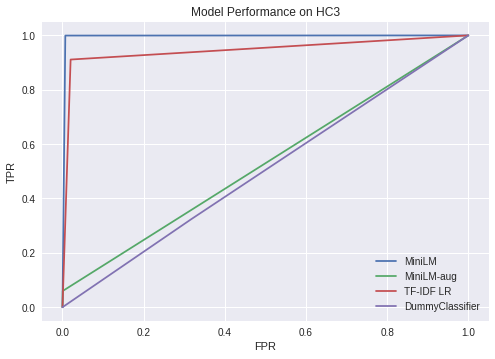

In [32]:
plt.style.use("seaborn")
plt.plot(fpr, tpr)
plt.plot(fpr_aug, tpr_aug)
plt.plot(fpr_3, tpr_3)
plt.plot(fpr_2, tpr_2)
plt.legend(['MiniLM', 'MiniLM-aug', 'TF-IDF LR', 'DummyClassifier'])
plt.title("Model Performance on HC3")
plt.xlabel("FPR")
plt.ylabel("TPR")
# plt.xscale('log')
# plt.yscale('log')
plt.savefig("res")